<a href="https://colab.research.google.com/github/ipevendelin/Nonlinear-Dimensionality-Reduction/blob/main/ADAML25_WK7_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Visualizing with SOM (3 points)
Visualize MNIST-784 handwritten digits dataset with SOM and discuss what you can learn
from the visualization.

In [1]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=72959bd3ec41fdc8b4aefeb38a3972a67a9d5cde0bc19b7be95a7c2bf4252548
  Stored in directory: /root/.cache/pip/wheels/0f/8c/a4/5b7aa56fa6ef11d536d45da775bcc5a2a1c163ff0f8f11990b
Successfully built minisom


#Imports

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
import seaborn as sns
import kagglehub
import os

%matplotlib inline
sns.set(style="whitegrid", font_scale = 1.1)

#Get the data

In [5]:

# Download latest version
path = kagglehub.dataset_download("aadeshkoirala/mnist-784")
print("Path to dataset files:", path)

# Construct the full path to the specific CSV file
csv_file_path = os.path.join(path, "mnist_784.csv")

print(f"Loading data from: {csv_file_path}")

# Load MNIST dataset
df_train = pd.read_csv(csv_file_path)

print(f"\nDataset loaded: {df_train.shape[0]} samples, {df_train.shape[1]} columns")


Using Colab cache for faster access to the 'mnist-784' dataset.
Path to dataset files: /kaggle/input/mnist-784
Loading data from: /kaggle/input/mnist-784/mnist_784.csv

Dataset loaded: 70000 samples, 785 columns


# Scale the data

In [6]:
# Separate features (X) and labels (y)
X = df_train.drop('class', axis=1).values.astype('float32')
y = df_train['class'].values

# Normalize the features
X = X / 255.0

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (70000, 784)
Labels shape: (70000,)


#Methodology

The Self-Organizing Map was configured with a 20×20 grid structure, resulting in 400 individual neurons. Each neuron maintains a 784-dimensional weight vector corresponding to the input dimensionality of the flattened MNIST images. The training process involved 20,000 iterations. Before training, all pixel values were normalized to the range of 0 to 1. During training, the SOM learns to organize itself such that neighboring neurons respond to similar input patterns.

#Train SOM

In [7]:

grid_rows, grid_cols = 20, 20
input_len = X.shape[1]

som = MiniSom(
    x=grid_rows,
    y=grid_cols,
    input_len=input_len,
    sigma=2.5,
    learning_rate=0.5,
    neighborhood_function='gaussian',
    random_seed=42
)

print("Training SOM...\n")
som.train_random(X, num_iteration=20000, verbose=True)
print("Training complete.")

Training SOM...

 [ 20000 / 20000 ] 100% - 0:00:00 left 
 quantization error: 5.16612527703425
Training complete.


#SOM neuron weights


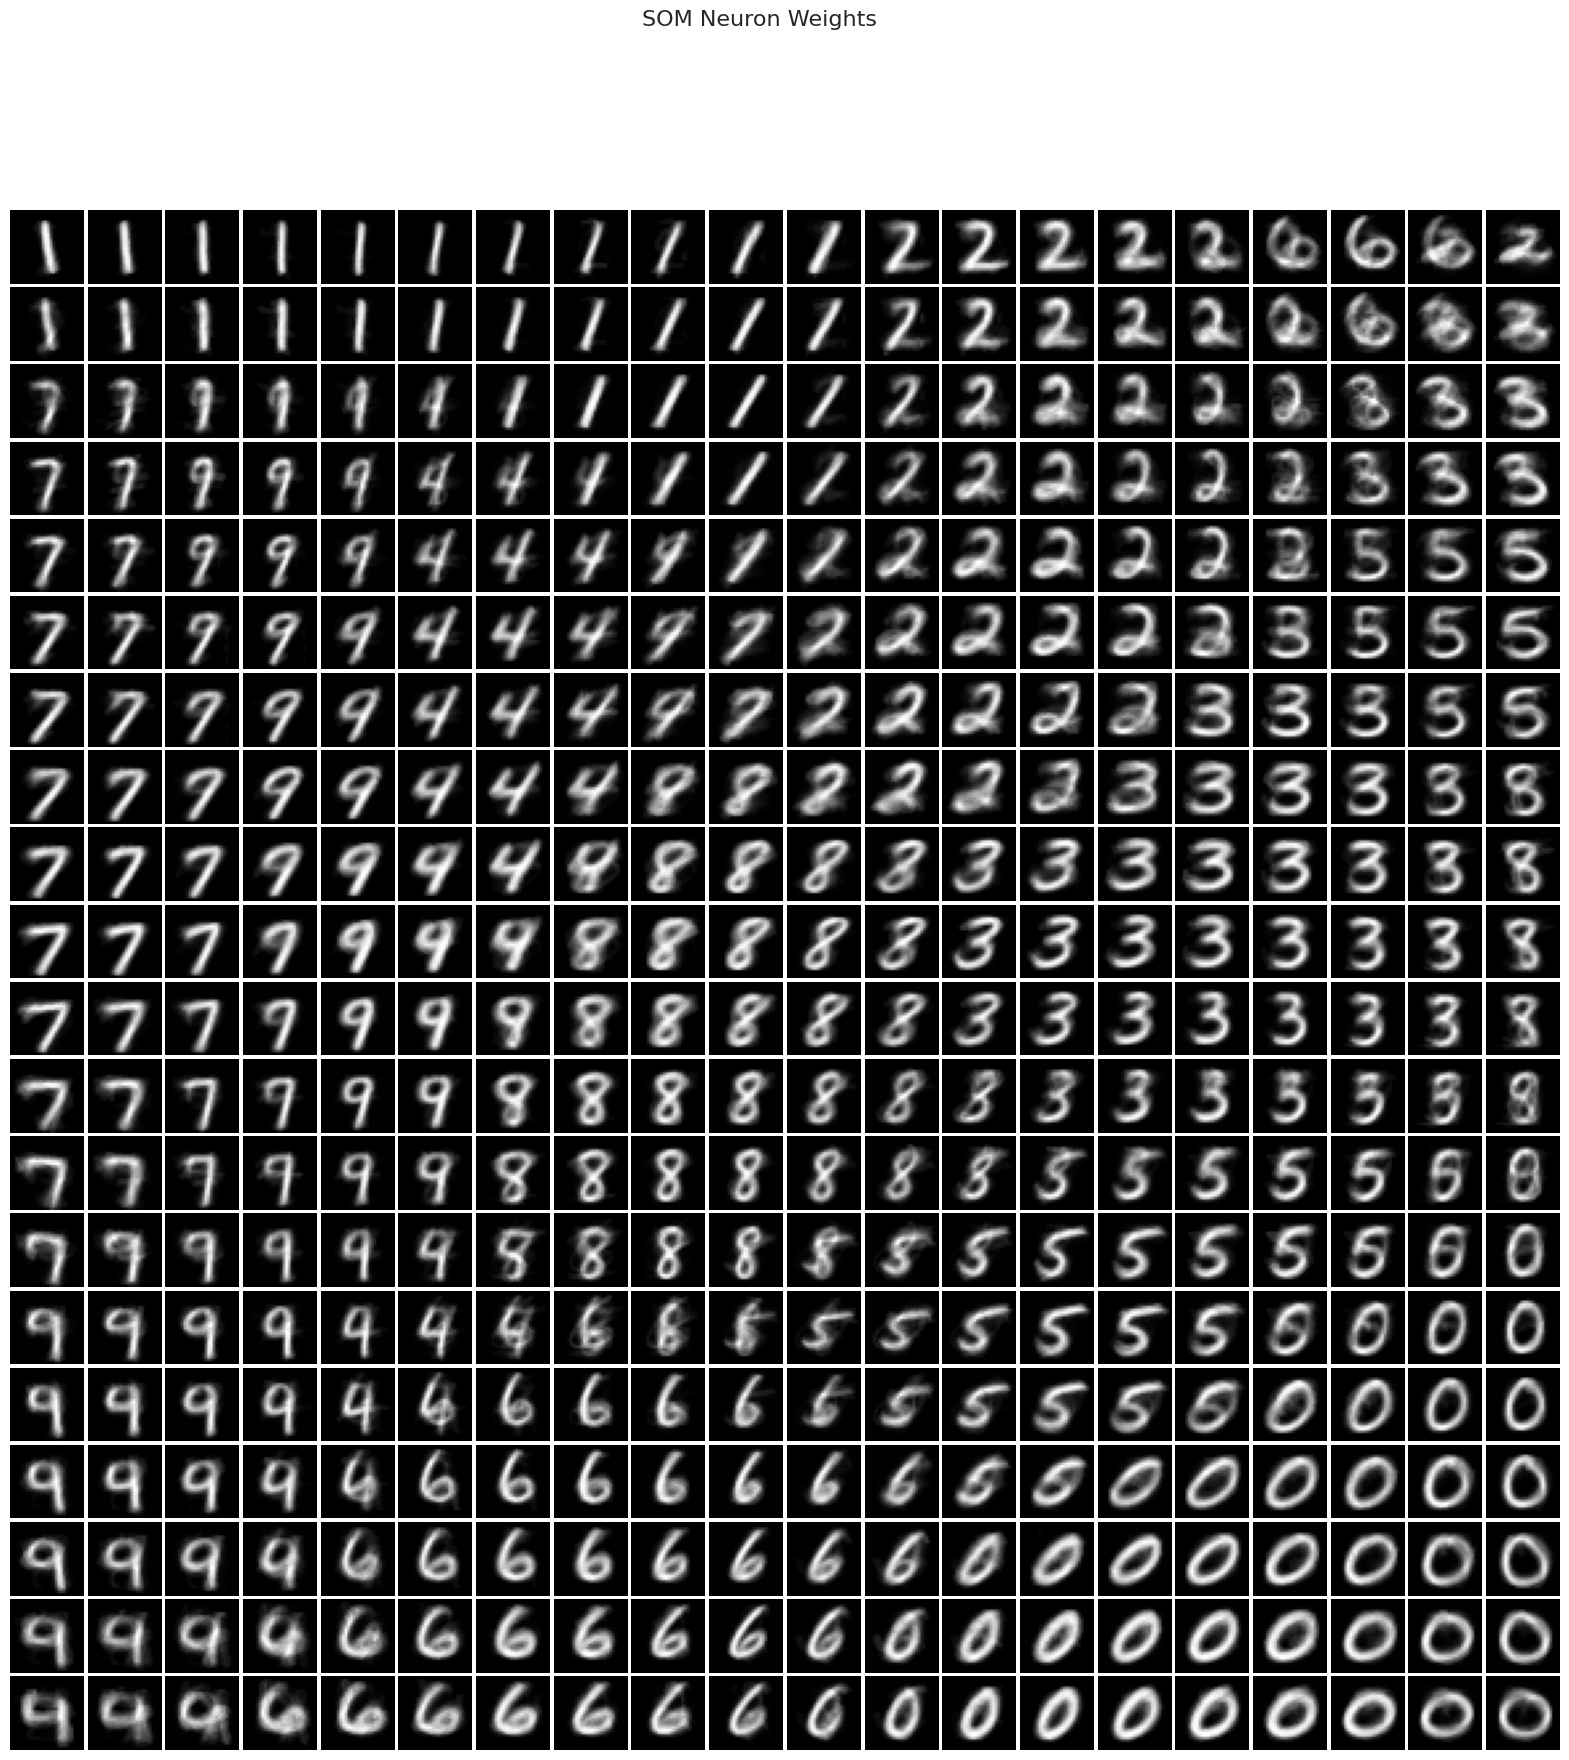

In [20]:
fig = plt.figure(figsize=(grid_cols, grid_rows))
for i in range(grid_rows):
    for j in range(grid_cols):
        ax = fig.add_subplot(grid_rows, grid_cols, i * grid_cols + j + 1)
        weights = som.get_weights()[i, j].reshape(28, 28)
        ax.imshow(weights, cmap='gray')
        ax.axis('off')

fig.suptitle("SOM Neuron Weights", fontsize=16)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

# Neuron Weights Visualization

The visualization of all 400 neuron weight vectors as 28×28 images reveals the complete landscape of learned prototypes across the entire SOM grid. From the visualization above we see the clear spatial organization of the network, where similar digit representations are positioned near each other on the grid. Like digit representation of ones is on the top left and zeros on bottom right. Neurons positioned at the boundaries between digit regions often represent unclearly written numbers. This shows the natural variability in handwritten digits in the data.

#SOM – U-Matrix

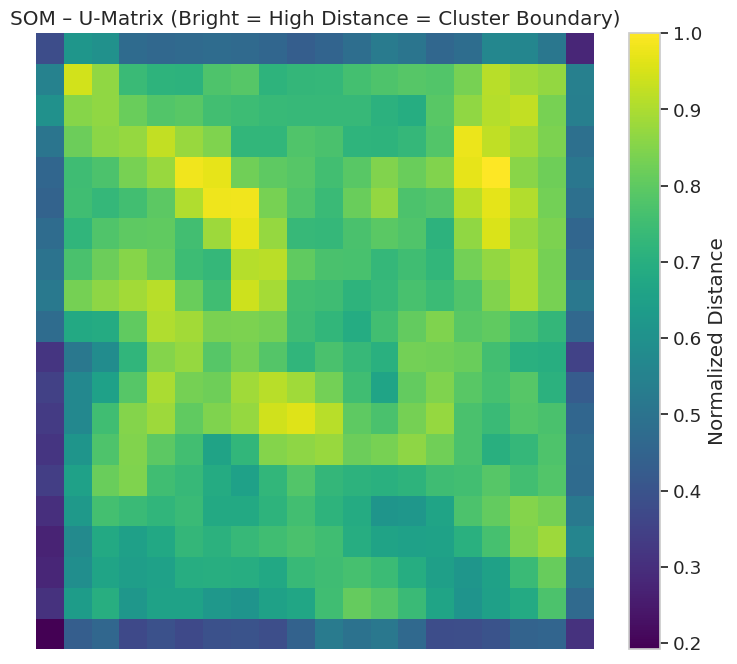

In [24]:

plt.figure(figsize=(9, 8))
plt.pcolor(som.distance_map().T, cmap='viridis')
plt.colorbar(label='Normalized Distance')
plt.title('SOM – U-Matrix (Bright = High Distance = Cluster Boundary)')
plt.axis('off')
plt.show()

## Analysis of the U-matrix

The U-Matrix visualization provides insights into the cluster structure discovered by the SOM. In this visualization, brighter colors (yellow and green) indicate high inter-neuron distances, which correspond to cluster boundaries where the data transitions from one digit class to another. Vice versa, darker colors (purple and blue) show low distances between neighbors, indicating cohesive cluster centers where neurons have very similar weight vectors.

 The interior of the map displays several regions with varying distance patterns, suggesting that the SOM has identified multiple subclusters within the data. These subclusters likely correspond to different stylistic variations within each digit class. Large dark purple-to-blue areas indicate homogeneous regions where the SOM has learned stable prototypes, typically corresponding to a single digit class with its natural variations. The presence of these well-defined clusters confirms that the SOM has successfully discovered the inherent structure in the handwritten digit data.

#SOM – Majority Label per Neuron



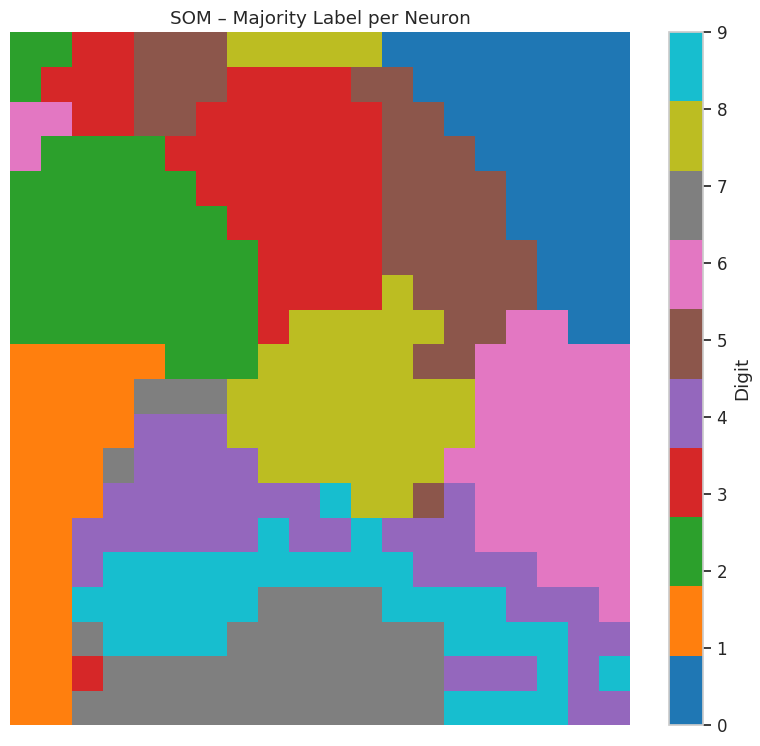

In [15]:


label_map = np.full((grid_rows, grid_cols), np.nan)

# Get the winning neuron for each data point and the indices of the data points
win_map = som.win_map(X, return_indices=True)

# Determine the most frequent label for each node
for (i, j), sample_indices in win_map.items():
    if sample_indices:
        sample_labels = y[sample_indices]

        if len(sample_labels) > 0:
            # Count occurrences of each label and find the most frequent
            label_counts = np.bincount(sample_labels)
            most_frequent_label = np.argmax(label_counts)
            label_map[i, j] = most_frequent_label


plt.figure(figsize=(10, 9))
cmap = plt.get_cmap('tab10', 10)
im = plt.pcolor(label_map.T, cmap=cmap, vmin=0, vmax=9)
plt.colorbar(im, ticks=range(10), label='Digit')
plt.title('SOM – Majority Label per Neuron')
plt.axis('off')
plt.show()

# Interpriation of Label mapping

The majority label mapping visualization assigns each neuron the digit label that appears most frequently among all training samples mapped to that neuron. This visualization illustrates the cpability of SOM to separate all different digit classes into distinct regions on the two-dimensional grid. Each color in the visualization represents a different digit from zero to nine. In it we can clearly see how the SOM has partitioned the grid into different colorcoded sections. Most digits occupy one of these large contiguous regions. For example the dark blue region in the top-left portion of the grid primarily contains digit zero and the orange on the bottom left contains digit one.

 Some regions show mixed labels or smaller isolated clusters, which may represent digits with unclear writing styles or outliers that share visual characteristics with multiple digit classes

#Hit map

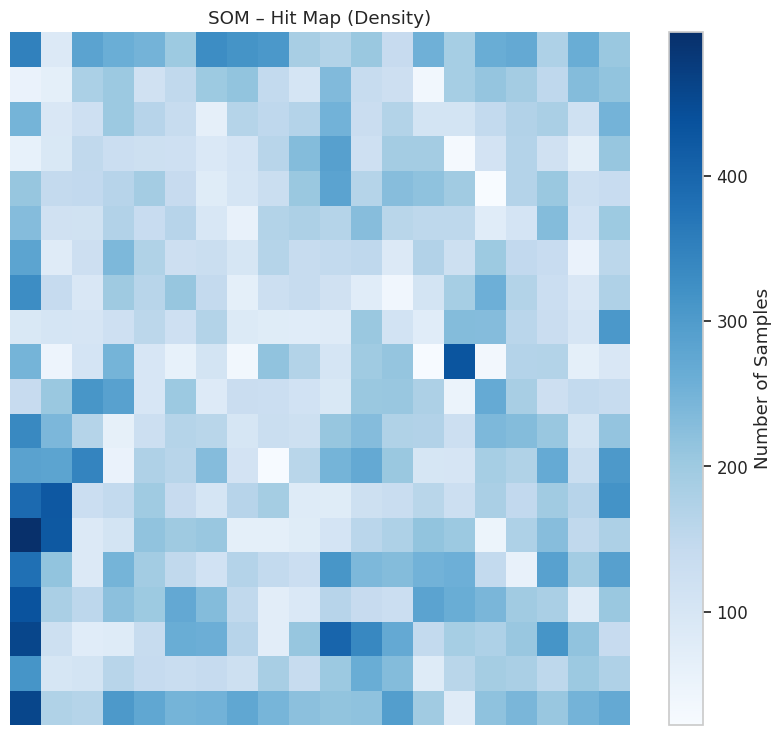

In [16]:
# Calculate the hit map (number of samples mapped to each neuron)
hits = np.zeros((grid_rows, grid_cols))
for i, data_point in enumerate(X):
    bmu = som.winner(data_point)
    hits[bmu[0], bmu[1]] += 1

plt.figure(figsize=(10, 9))
plt.pcolor(hits.T, cmap='Blues')
plt.colorbar(label='Number of Samples')
plt.title('SOM – Hit Map (Density)')
plt.axis('off')
plt.show()

#Analysis of hit map

The hit map visualization reveals how training samples are distributed across the SOM grid, with color intensity indicating the number of samples mapped to each neuron. The distribution is notably uneven, with some neurons receiving significantly more samples than others. Darker blue regions indicate high-density neurons that attracted over 400 training samples, while lighter colors show neurons that received only 100 or less samples.


High-density regions typically correspond to the centers of digit clusters, where the most prototypical or common patterns are represented. These neurons capture the average look of each digit class based on the training data. Conversely, low-density regions often mark the boundaries between different digit clusters. There SOM has positioned neurons to represent transitional or interpolated patterns.

#Prototyes

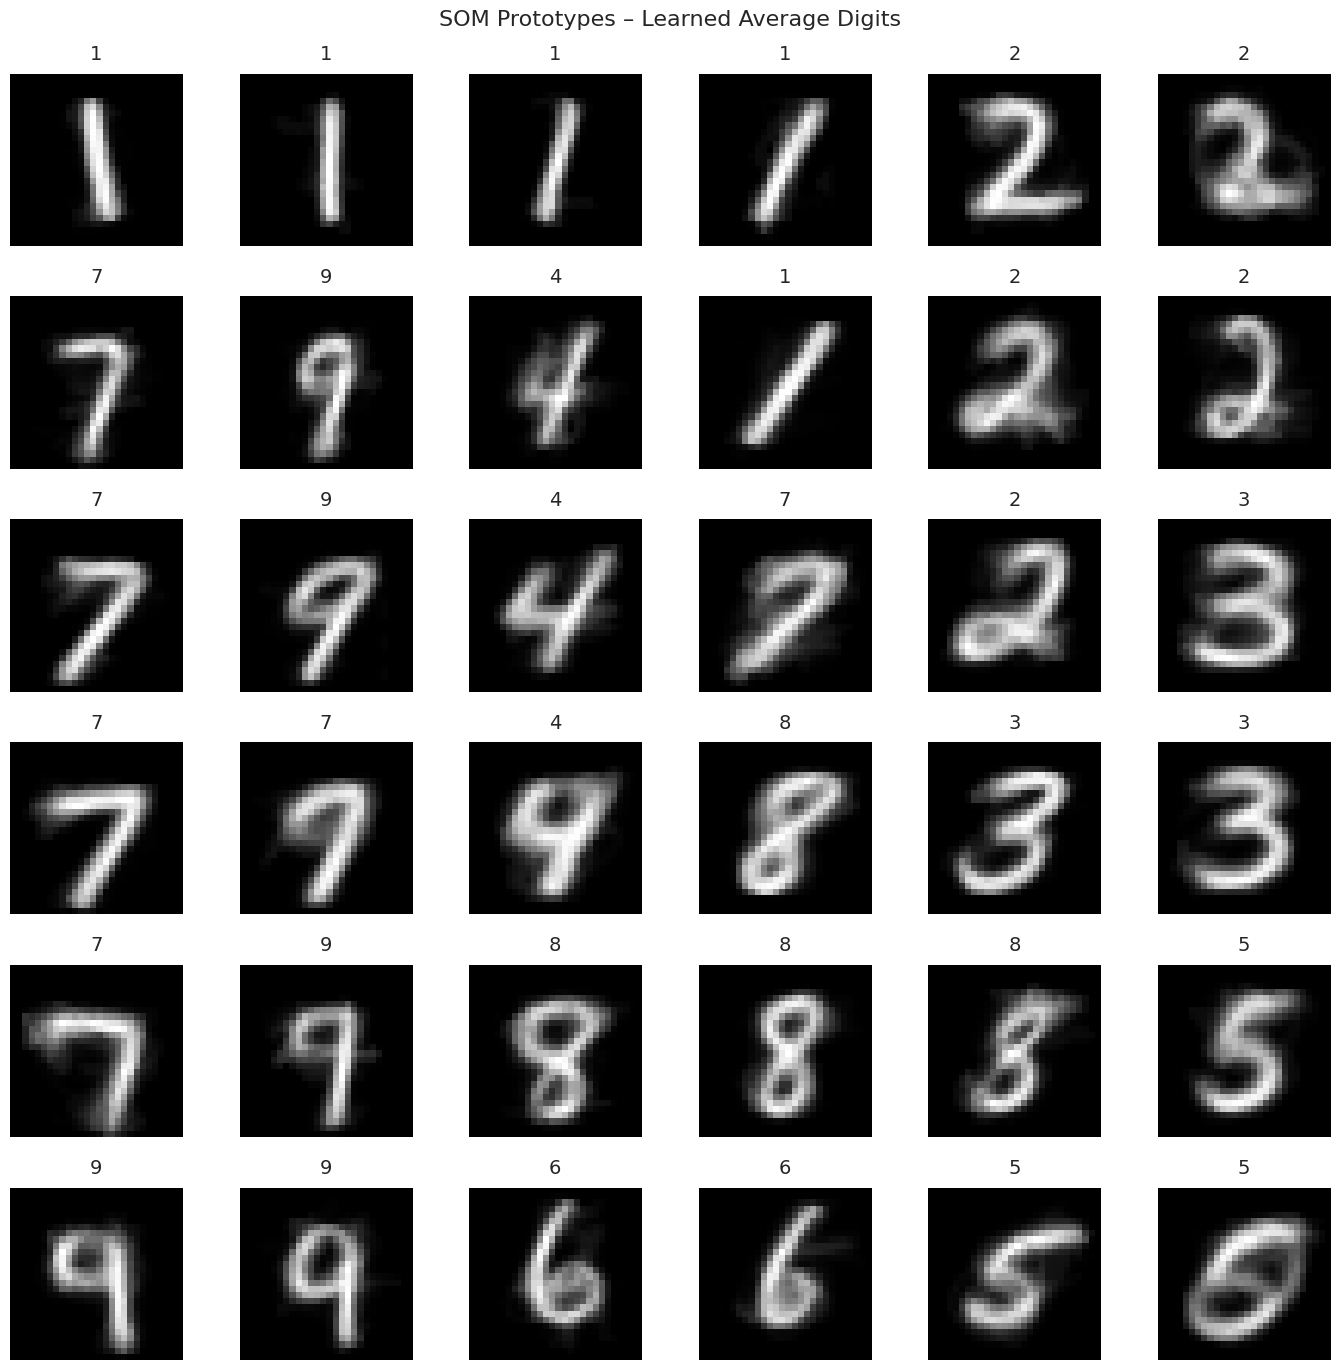

In [25]:
plt.figure(figsize=(14, 14))
n_examples = 36
for idx in range(n_examples):
    row = idx // 6
    col = idx % 6
    # Pick neuron from grid
    x_idx = (row * 3) % grid_rows
    y_idx = (col * 3) % grid_cols
    if x_idx < grid_rows and y_idx < grid_cols:
        plt.subplot(6, 6, idx + 1)
        weights = som.get_weights()[x_idx, y_idx].reshape(28, 28)
        plt.imshow(weights, cmap='gray', interpolation='nearest')
        plt.axis('off')
        if not np.isnan(label_map[x_idx, y_idx]):
            plt.title(f"{int(label_map[x_idx, y_idx])}", fontsize=14, pad=10)
plt.suptitle('SOM Prototypes – Learned Average Digits', fontsize=16)
plt.tight_layout()
plt.show()

# Prototypes interpretation
The prototype visualization displays a representative sample of 36 neurons arranged in a 6×6 grid, along with their majority digit labels. Each prototype represents the average characteristics of all samples mapped to that particular neuron. Prototypes positioned near cluster centers typically show very clean representations of digits. Most prototypes clearly resemble their assigned digit labels, with recognizable shapes that any human observer could easily identify. Those near cluster boundaries may show blended or unclearly written diggits. Like the digit 0 or 5 on the right corner.

Quite impressive is the fact that different neurons assigned to the same digit capture natural variations in writing style. For instance, multiple neurons represent the digit 1, but they show different angles that reflect the variety of how different people write this digit.